<font color = "red"> Binana close contacts! 

#### Overview 

| Task                                      | Description                                                   |
|-------------------------------------------|---------------------------------------------------------------|
| Run Binana                                | Execute Binana for all PDBs and poses                         |
| Read logfile                              | Create a dictionary with information from log files           |
| Getting dict info                         | - Close Contacts [OK] <br> - Hydrogen Bonds                  |
| Extract atom properties (RDkit)           | - Atom Index <br> - Name <br> - Mass <br> - Charge <br> - Element Name <br> - Hybridization <br> - Num Hydrogens <br> - Formal Charge <br> - Unpaired Electron <br> - In Aromatic Substructure |
| Preparing data for graph                  | - protgraph_dict[pdb][pose] = {<br>&nbsp;&nbsp;&nbsp;&nbsp;'x_s': x_s (ligand properties),<br>&nbsp;&nbsp;&nbsp;&nbsp;'x_t': x_t (receptor properties),<br>&nbsp;&nbsp;&nbsp;&nbsp;'edge_index': edge_index (Matrix [2, number of connections]),<br>&nbsp;&nbsp;&nbsp;&nbsp;'edge_attr': edge_attr (Vector [distances])<br>} |
| Protgraph_dict                            | --> BipartiteData data  --> Dataset list  --> DataLoader  --> Graph Attention Model |


### Libraries 

In [9]:
from tqdm import tqdm
import pickle
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import subprocess
import numpy as np
import torch
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import os
from torch_geometric.loader import DataLoader
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GCNConv
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from collections import Counter
from torch_geometric.data import Data, Dataset
import json
import os
import pandas as pd
import pandas as pd
from rdkit import Chem
import torch
import numpy as np
from torch.utils.data import Dataset
import pickle
from collections import defaultdict
from pathlib import Path
import torch.nn.functional as F
import pickle

/home/lbcb02/anaconda3/envs/master_37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
import json 

In [10]:
%run ../Config.ipynb

In [11]:
%run ../Config.ipynb
config = Config()
pdbs = os.listdir(config.set)
nposes = config.docking_params['nposes']
batch_size  = config.model_args['batch_size']
path_scripts = Path(os.getcwd())
num_epochs = config.model_args['epochs']
num_folds = config.model_args['nfolds']
patience = config.model_args['patience']  # Set your desired patience value
binana_executable = config.executables['binana']

In [12]:
len(pdbs)

5316

#### Label 

Obs: "Error calculating RMSD for 4kz6 pose 1: No sub-structure match found between the reference
and probe mol"
<font color = 'red'> For  now, i will assume the label as 0 to just to begin!

* Observação: Tem que rodar o score similarity, antes de rodar o arquivo de label: 

### Read logfile

In [14]:
%%time
data_dict_all_logs_exp = defaultdict(dict)
data_dict_all_logs_docked = defaultdict(dict)
def read_logfile(pdb, pose=None):
    # Define the common part of the file path
    common_path = f"{config.set}/{pdb}/binana/binana_{pdb}"
    
    # Adjust the file path based on whether the pose parameter is provided
    path = common_path + (f"_pose_{pose}" if pose is not None else "") + "/log.txt"

     
    try: # Read the text file using Path
        with Path(path).open('r') as file:
            text = file.read()
    
    
        # Extract the content after "JSON Output:"
        json_text = text.split("JSON Output:")[1].strip()
        
        # Convert the JSON text to a dictionary
        data_dict = json.loads(json_text)
        
        # Store the data dictionary for the pose if pose is provided
        if pose is not None:
            data_dict_all_logs_docked[pdb][pose] = data_dict
        else:
            # Store the data dictionary for the pose (from the first code)
            data_dict_all_logs_exp[pdb] = data_dict

    except:
        print("Error when opening file ", path)
    
    return data_dict_all_logs_exp, data_dict_all_logs_docked

# Example usage: provide pose parameter for the second code, leave it empty for the first code
for pdb in pdbs:
    read_logfile(pdb)  # Run logic from the first code
    for pose in range(1, nposes + 1):
        read_logfile(pdb, pose)  # Run logic from the second code

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 10.5 µs


* 1min 30s

In [7]:
#data_dict_all_logs_docked.get('2qbq')

### Getting dict info 

In [8]:
%%time
def flatten_data(df, pdb, pose = False):
    flat_data = []
    if pose == False:
        data = df[pdb]['closeContacts']
    else:
        data = df[pdb][pose]['closeContacts']
    
    for entry in data:
        flat_entry = {
            'ligand_atom_index': entry['ligandAtoms'][0]['atomIndex'],
            'ligand_atom_name': entry['ligandAtoms'][0]['atomName'],
            'ligand_chain': entry['ligandAtoms'][0]['chain'],
            'ligand_resID': entry['ligandAtoms'][0]['resID'],
            'ligand_resName': entry['ligandAtoms'][0]['resName'],
            #'angle': entry['metrics']['angle'],
            'distance': entry['metrics']['distance'],
            'receptor_atom_index': entry['receptorAtoms'][0]['atomIndex'],
            'receptor_atom_name': entry['receptorAtoms'][0]['atomName'],
            'receptor_chain': entry['receptorAtoms'][0]['chain'],
            'receptor_resID': entry['receptorAtoms'][0]['resID'],
            'receptor_resName': entry['receptorAtoms'][0]['resName'],
        }
        flat_data.append(flat_entry)

    return pd.DataFrame(flat_data)


CPU times: user 0 ns, sys: 5 µs, total: 5 µs
Wall time: 8.11 µs


In [9]:
#data_dict_all_logs_docked.get("1uz8")

In [15]:
%%time
data_frames_exp = []

# Iterate over each PDB in the list
for pdb in pdbs:
    try:
        # Attempt to flatten the data and add the 'pdb' column
        flattened_data = flatten_data(data_dict_all_logs_exp, pdb).assign(pdb=pdb)
        # Append the flattened data frame to the list
        data_frames_exp.append(flattened_data)
        #print(f'Sucess processing PDB {pdb}')
    except Exception as e:
        # If an exception occurs, print the error and continue to the next iteration
        print(f"Error processing PDB {pdb}: {e}")

# Concatenate all data frames in the list along the rows
data_frame_exp = pd.concat(data_frames_exp, axis=0)

Error processing PDB 3oy8: name 'flatten_data' is not defined
Error processing PDB 5qa8: name 'flatten_data' is not defined
Error processing PDB 3ocz: name 'flatten_data' is not defined
Error processing PDB 4pv5: name 'flatten_data' is not defined
Error processing PDB 3qxv: name 'flatten_data' is not defined
Error processing PDB 3p8n: name 'flatten_data' is not defined
Error processing PDB 1uz8: name 'flatten_data' is not defined
Error processing PDB 1b3h: name 'flatten_data' is not defined
Error processing PDB 4eor: name 'flatten_data' is not defined
Error processing PDB 4g0p: name 'flatten_data' is not defined
Error processing PDB 6jad: name 'flatten_data' is not defined
Error processing PDB 2xjg: name 'flatten_data' is not defined
Error processing PDB 3gk1: name 'flatten_data' is not defined
Error processing PDB 3znr: name 'flatten_data' is not defined
Error processing PDB 1w5y: name 'flatten_data' is not defined
Error processing PDB 2j7g: name 'flatten_data' is not defined
Error pr

In [11]:
data_frame_exp[(data_frame_exp["pdb"] == "4eor")][['pdb','ligand_atom_index','ligand_atom_name','receptor_atom_index','receptor_atom_name','distance']].head()

,pdb,ligand_atom_index,ligand_atom_name,receptor_atom_index,receptor_atom_name,distance


In [12]:
%%time
# Create a list of DataFrames with the specified conditions
data_frames_docked = [
    flatten_data(data_dict_all_logs_docked, pdb, pose).assign(pdb=pdb, pose=str(pose))
    for pdb in pdbs
    for pose in range(1, nposes)
    if pose in data_dict_all_logs_docked.get(pdb, {})
]

# Concatenate the DataFrames
data_frame_docked = pd.concat(data_frames_docked, axis=0)

CPU times: user 1min 51s, sys: 2.25 s, total: 1min 53s
Wall time: 1min 58s


#### Filtering by distance 

In [13]:
data_frame_docked[data_frame_docked['pdb'] =='5qa8']

,ligand_atom_index,ligand_atom_name,ligand_chain,ligand_resID,ligand_resName,distance,receptor_atom_index,receptor_atom_name,receptor_chain,receptor_resID,receptor_resName,pdb,pose


In [61]:
cut = 4 

In [15]:
data_frame_docked = data_frame_docked[data_frame_docked['distance'] < cut]
data_frame_exp = data_frame_exp[data_frame_exp['distance']<cut]

#### Report 

In [16]:
foureor1 = data_frame_docked[(data_frame_docked["pdb"] == "4eor") & (data_frame_docked["pose"] == "1")][['pdb','pose','ligand_atom_index','ligand_atom_name','receptor_atom_index','receptor_atom_name','distance']]

In [17]:
foureor1.head()

,pdb,pose,ligand_atom_index,ligand_atom_name,receptor_atom_index,receptor_atom_name,distance


In [18]:
foureor1['receptor_atom_name'].value_counts()

Series([], Name: receptor_atom_name, dtype: int64)

In [19]:
foureor1['receptor_atom_index'].value_counts().reset_index(name = "count").head(10)

,index,count


In [20]:
foureor1.head()

,pdb,pose,ligand_atom_index,ligand_atom_name,receptor_atom_index,receptor_atom_name,distance


In [21]:
foureor1[(foureor1["pdb"] == "4eor") & (foureor1["receptor_atom_index"] == 75)]

,pdb,pose,ligand_atom_index,ligand_atom_name,receptor_atom_index,receptor_atom_name,distance


In [22]:
foureor1['ligand_atom_name'].nunique()

0

In [23]:
foureor1['receptor_atom_index'].nunique()

0

In [24]:
#receptor_id_resi_atom = foureor1[["receptor_resID","receptor_atom_index"]]

In [25]:
#receptor_id_resi_atom['receptor_resID'].nunique()

In [26]:
#foureor1.groupby("receptor_resID")['receptor_atom_index'].nunique()

In [27]:
#foureor1.groupby("receptor_resID")['receptor_atom_index'].value_counts()

In [28]:
#foureor1[foureor1['receptor_resID'] ==11][["receptor_resID","receptor_atom_index",'ligand_atom_index', 'receptor_atom_name','receptor_resName']]

In [29]:
df = data_frame_docked.copy()

In [30]:
df[df['pdb'] == '5qa8'].head()

,ligand_atom_index,ligand_atom_name,ligand_chain,ligand_resID,ligand_resName,distance,receptor_atom_index,receptor_atom_name,receptor_chain,receptor_resID,receptor_resName,pdb,pose


In [31]:
#df['pdb'].nunique()

#### List of indexes  

- Create a dictionary with the **indices** of close-contact atoms.

- This is necessary so that we know from which atoms we should **obtain the properties.**

- Dictionaries for experimental data and for poses obtained through docking, for the comparison **metric of native contacts.**

<font color = "red"> Why i used process_ids to sort the values ?

In [32]:
data_frame_docked[data_frame_docked['pdb']== '5qa8'].head()

,ligand_atom_index,ligand_atom_name,ligand_chain,ligand_resID,ligand_resName,distance,receptor_atom_index,receptor_atom_name,receptor_chain,receptor_resID,receptor_resName,pdb,pose


In [33]:
%%time
def process_ids(data_frame, pdb,  ligand_column, pose = False):
    if 'pose' in data_frame.columns:
        aux = list(data_frame[(data_frame['pdb'] == pdb) & (data_frame['pose'] == str(pose))][ligand_column])
    else:
        aux = list(data_frame[data_frame['pdb'] == pdb][ligand_column])
    try:
        aux = [int(val) for val in aux]
    except ValueError:
        pass
    return aux

def process_pdb_data(pdbs, data_frame, ligand_column):
    ids = {}
    for pdb in pdbs:
        if 'pose' in data_frame.columns:
            ids[pdb] = {}
            for pose in range(1, nposes + 1):
                ids[pdb][pose] = process_ids(data_frame, pdb,  ligand_column, pose)
        else:
            ids[pdb] = process_ids(data_frame, pdb, ligand_column)
    return ids

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 10.5 µs


In [34]:
combined_dict = {
    'ids_lig_with_poses': process_pdb_data(pdbs, data_frame_docked, 'ligand_atom_index'),
    'ids_rec_with_poses': process_pdb_data(pdbs, data_frame_docked, 'receptor_atom_index'),
    'ids_lig_exp': process_pdb_data(pdbs, data_frame_exp, 'ligand_atom_index'),
    'ids_rec_exp': process_pdb_data(pdbs, data_frame_exp, 'receptor_atom_index')}

if process_ids: 
    # Save combined dictionary using pickle
    with open(f'{config.root}/{config.project_name}/{config.dicts}/combined_dicts_ids.pkl', 'wb') as f:
        pickle.dump(combined_dict, f)
else: 
    with open(f'{config.root}/{config.project_name}/{config.dicts}/combined_dicts_ids.pkl','rb') as f:
        combined_dict = pickle.load(f)

* Todos - PDBS - 15h 17min 49s
* 284 - PDBs - 3 min 26s 

In [36]:
#ids_rec_exp['1owh'][1:10]

In [37]:
#ids_lig_exp['1owh'][1:10]

In [38]:
ids_rec_with_poses['5qa8']

{1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}

### Compare native contacts

In [22]:
%%time
calculate_score = False
def compare_graphs(pairs_graph1, pairs_graph2):
    """
    Compare two sets of graph pairs and calculate a similarity score.

    Parameters
    ----------
    pairs_graph1 : list
        List of pairs from the first graph.
    pairs_graph2 : list
        List of pairs from the second graph.

    Returns
    -------
    float
        Percentage similarity between the two graphs.
    """
    common_pairs = [pair for pair in pairs_graph1 if pair in pairs_graph2]
    #print(len(common_pairs))
    similarity_score = (len(common_pairs) / len(pairs_graph2)) * 100
    return similarity_score

if calculate_score: 
    score = {}
    for pdb in tqdm(pdbs):
        #print('pdb: ', pdb)
        score[pdb] = {}
        for pose in range(1, nposes + 1):

            try: 
                pairs_graph1 = list(zip(ids_lig_with_poses[pdb][pose], ids_rec_with_poses[pdb][pose]))
                pairs_graph2 = list(zip(ids_lig_exp[pdb], ids_rec_exp[pdb]))
                score[pdb][pose] = compare_graphs(pairs_graph1, pairs_graph2)
    
            except Exception as e:
                print(e)
    
    with open(f"{config.data}/score.json", "w") as json_file:
        json.dump(score, json_file)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.3 µs


<font color = "yellow"> When i extrated the atom properties, i only extrated for  ids_3gv9_pose_1

Why am i taking this?

     * Because we only want properties from the important nodes

#### Label 

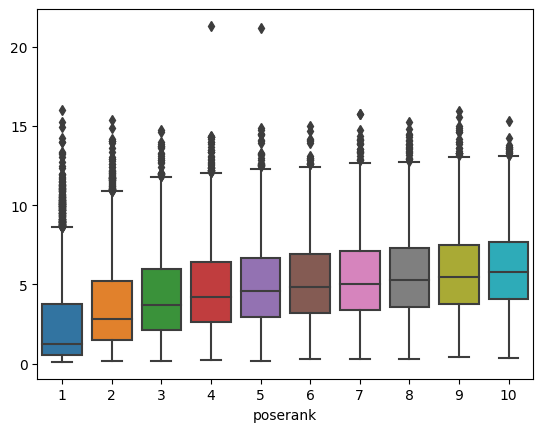

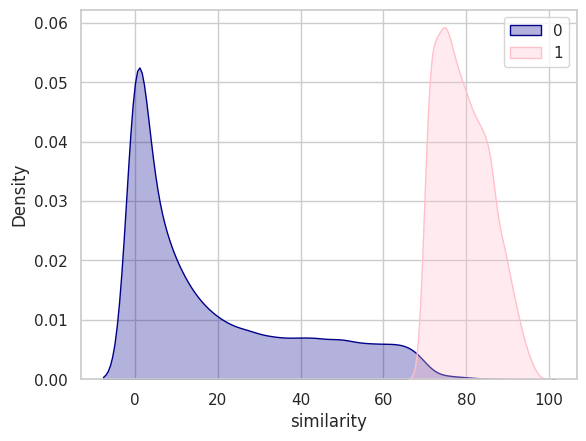

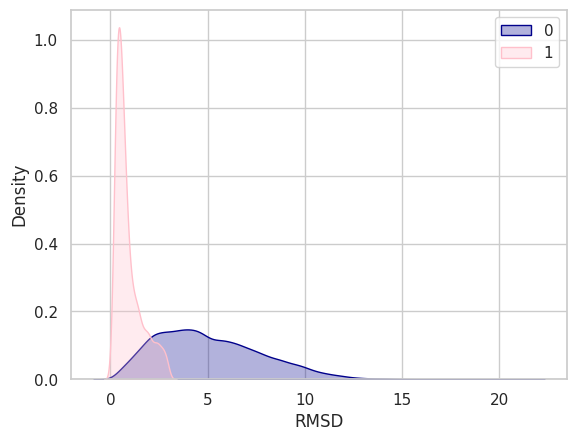

label.json saved at: ../Datahub/Data


5316

In [42]:
%run Label.ipynb
label = pd.read_json(f"{config.data}/label.json").fillna(0)
len(label.columns)

### Extract atom properties

In [43]:
def find_element_index(lst, element):
    """
    Locate the index of the desired element within the list. If the element is not found, return the index of the last item.
    """
    try:
        return lst.index(element)
    except ValueError:
        return len(lst) - 1

In [44]:
class AtomPropertiesExtractor:
    def __init__(self):
        #self.ligand_path = ligand_path
        self.columns = ["Atom_Index", "Name", "Mass", "Charge", "Element_Name", "Hybridization", "Num_Hydrogens", "Formal_Charge", "Unpaired_Electron", "In_Aromatic_Substructure"]
        self.allowable_features = {
            "possible_hybridization_list": ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "UNSPECIFIED"],
            "possible_atoms": ['C', 'S', 'N', 'O', 'H']
        }

    def extract_properties(self, atom_indices, properties_to_extract, path):
        atom_properties_list = []

        with open(path, "r") as pdb_file:
            pdb_data = pdb_file.read()

        molecule = Chem.MolFromPDBFile(path, removeHs=False)

        if molecule is not None:
            for atom_index in atom_indices:
                atom = molecule.GetAtomWithIdx(atom_index - 1)

                atom_properties = {
                    "Atom_Index": atom_index,
                    "Name": atom.GetSymbol(),
                    "Mass": atom.GetMass(),
                    "Charge": atom.GetFormalCharge(),
                    "Element_Name": find_element_index(self.allowable_features['possible_atoms'], str(atom.GetSymbol())),
                    "Hybridization": find_element_index(self.allowable_features['possible_hybridization_list'], str(atom.GetHybridization())),
                    "Num_Hydrogens": atom.GetTotalNumHs(),
                    "Formal_Charge": atom.GetFormalCharge(),
                    "Unpaired_Electron": atom.GetNumRadicalElectrons(),
                    "In_Aromatic_Substructure": int(atom.GetIsAromatic())
                }

                atom_properties = {key: atom_properties[key] for key in properties_to_extract}
                atom_properties_list.append(atom_properties)

        atom_properties_df = pd.DataFrame(atom_properties_list, columns=properties_to_extract)
        return atom_properties_df

In [45]:
# Create an instance of the class
atom_ligand_extractor = AtomPropertiesExtractor()
atom_receptor_extractor =  AtomPropertiesExtractor()

In [46]:
#atom_receptor_extractor.extract_properties(ids_lig['3gv9'][2], node_descriptors, ligand_path.as_posix())

#### Simple analysis

In [47]:
#extract_atom_properties(ligand_path.as_posix(), ids_lig['3gv9'][2])

In [48]:
#atom_ligand_extractor.extract_properties(ids_lig['3gv9'][1], config.node_descriptors, '/home/lbcb02/Workspace/Scripts/coreset/3gv9/results/pose_1.pdb')

In [49]:
#ids_lig['3gv9'][2]

In [50]:
df.head()

,ligand_atom_index,ligand_atom_name,ligand_chain,ligand_resID,ligand_resName,distance,receptor_atom_index,receptor_atom_name,receptor_chain,receptor_resID,receptor_resName,pdb,pose
0,1.0,C4,d,1.0,GCO,3.841470,524.0,OE2,A,71.0,GLU,3oy8,1
1,2.0,C3,d,1.0,GCO,3.889396,499.0,NE1,A,68.0,TRP,3oy8,1
2,5.0,O11,d,1.0,GCO,3.934584,391.0,CD2,A,52.0,HIS,3oy8,1
3,5.0,O11,d,1.0,GCO,3.825708,393.0,NE2,A,52.0,HIS,3oy8,1
4,6.0,O12,d,1.0,GCO,3.219586,359.0,NH2,A,48.0,ARG,3oy8,1


In [51]:
df['receptor_atom_name'].nunique()

82

In [52]:
df['ligand_atom_name'].value_counts().head(10)

C2    75093
C6    70910
C5    65841
C4    65408
C3    59305
O2    58853
C1    56205
O1    52407
H1    51759
N1    48100
Name: ligand_atom_name, dtype: int64

#### Pose rank encoding 

In [53]:
#global_encoding = pd.get_dummies(df['receptor_atom_name'], prefix='encoded_global')

In [54]:
global_encoding_rank = pd.get_dummies(df['pose'], prefix='pose')

In [55]:
global_encoding_rank.head()

,pose_1,pose_2,pose_3,pose_4,pose_5,pose_6,pose_7,pose_8,pose_9
0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0


In [56]:
#pose_rank_mean = label.T.mean().reset_index().rename(columns = {'index':'pose', 0: 'mean_pose_rank'})
prob_pose_rank = (label.sum(axis = 1) / label.sum().sum()).reset_index().rename(columns = {'index':'pose', 0: 'prob_pose_rank'})

In [57]:
prob_pose_rank

,pose,prob_pose_rank
0,1,0.559428
1,2,0.199560
2,3,0.090609
3,4,0.055026
4,5,0.038518
5,6,0.022377
6,7,0.016875
7,8,0.010638
8,9,0.006970
9,10,0.000000


In [58]:
#pose_rank_mean['pose'] = pose_rank_mean['pose'].astype(str)
prob_pose_rank['pose'] = prob_pose_rank['pose'].astype(str)

In [59]:
#df = pd.concat([df, global_encoding], axis = 1 )
#df.iloc[:,13:]

In [60]:
df.head(2)

,ligand_atom_index,ligand_atom_name,ligand_chain,ligand_resID,ligand_resName,distance,receptor_atom_index,receptor_atom_name,receptor_chain,receptor_resID,receptor_resName,pdb,pose
0,1.0,C4,d,1.0,GCO,3.841470,524.0,OE2,A,71.0,GLU,3oy8,1
1,2.0,C3,d,1.0,GCO,3.889396,499.0,NE1,A,68.0,TRP,3oy8,1


#### Extracting properties 

In [43]:
lig_atoms_prop = {}
rec_atoms_prop = {}
df_dict = {}

In [44]:
pose_rank = False 

In [45]:
with open(f'{config.root}/{config.project_name}/{config.dicts}/combined_dicts_ids.pkl','rb') as f:
    combined_dict = pickle.load(f)

In [46]:
%%time
for pdb in tqdm(pdbs, desc = "Processing PDBs"):
    lig_atoms_prop[pdb] = {}
    rec_atoms_prop[pdb] = {}
    df_dict[pdb] = {}
    print(pdb)

    try: 
        for pose in range(1, nposes+1):
            ligand_path =   f"{config.set}/{pdb}/results/pose_{pose}.pdb"
            protein_path =  f"{config.set}/{pdb}/{pdb}_protein_fixed.pdb"
    
            lig = atom_ligand_extractor.extract_properties(combined_dict["ids_lig_with_poses"][pdb][pose], config.node_descriptors, ligand_path)
            if pose_rank:
                lig['prob_pose_rank'] = round(prob_pose_rank[prob_pose_rank['pose'] == str(pose)]['prob_pose_rank'].values[0], 5)      
        
            lig_atoms_prop[pdb][pose] = lig
            
            try:
                rec = atom_receptor_extractor.extract_properties(combined_dict["ids_rec_with_poses"][pdb][pose], config.node_descriptors, protein_path)#.drop(columns = 'Name')
    
                if pose_rank:
                    rec['prob_pose_rank'] = round(prob_pose_rank[prob_pose_rank['pose'] == str(pose)]['prob_pose_rank'].values[0], 5)      
        
                rec_atoms_prop[pdb][pose] = rec 
            except Exception as e:
                print(e)
           
            df_dict[pdb][pose] = df[(df['pdb']==pdb) & (df['pose']==str(pose))]
            #print(rec_atoms_prop[pdb][pose].shape)
            #print(lig_atoms_prop[pdb][pose].shape)
    except Exception as e:
        print(e)

Processing PDBs: 100%|███████████████████| 5316/5316 [00:00<00:00, 59554.85it/s]

3oy8
name 'atom_ligand_extractor' is not defined
5qa8
name 'atom_ligand_extractor' is not defined
3ocz
name 'atom_ligand_extractor' is not defined
4pv5
name 'atom_ligand_extractor' is not defined
3qxv
name 'atom_ligand_extractor' is not defined
3p8n
name 'atom_ligand_extractor' is not defined
1uz8
name 'atom_ligand_extractor' is not defined
1b3h
name 'atom_ligand_extractor' is not defined
4eor
name 'atom_ligand_extractor' is not defined
4g0p
name 'atom_ligand_extractor' is not defined
6jad
name 'atom_ligand_extractor' is not defined
2xjg
name 'atom_ligand_extractor' is not defined
3gk1
name 'atom_ligand_extractor' is not defined
3znr
name 'atom_ligand_extractor' is not defined
1w5y
name 'atom_ligand_extractor' is not defined
2j7g
name 'atom_ligand_extractor' is not defined
1m2p
name 'atom_ligand_extractor' is not defined
6hai
name 'atom_ligand_extractor' is not defined
1xff
name 'atom_ligand_extractor' is not defined
4ryd
name 'atom_ligand_extractor' is not defined
6cdo
name 'atom_liga

In [47]:
process_atoms_prop = False

if process_atoms_prop:
    combined_dict_atoms_prop = {
    'lig_atoms_prop': lig_atoms_prop,
    'rec_atoms_prop': rec_atoms_prop,
    'df_dict': df_dict}
    
    # Save combined dictionary using pickle
    with open(f'{config.root}/{config.project_name}/{config.dicts}/combined_dicts_atoms_prop.pkl', 'wb') as f:
        pickle.dump(combined_dict_atoms_prop, f)
else: 
    with open(f'{config.root}/{config.project_name}/{config.dicts}/combined_dicts_atoms_prop.pkl','rb') as f:
        combined_dict_atoms_prop = pickle.load(f)

Obs: **6min 4s for 284 PDBs**

<font color = 'yellow'> **Put save point here!**

<font color = red> Should i keep L, R? 

In [48]:
#lig_atoms_prop['Atom_Index'] = "L" + lig_atoms_prop['Atom_Index'].astype(str)
#rec_atoms_prop['Atom_Index'] = "R" + rec_atoms_prop['Atom_Index'].astype(str)

### Preparing data for graph

Obs: For 3gr2 pose 10 we have nothing! 

In [49]:
#torch.tensor(np.array(lig_atoms_prop['3gr2'][10].iloc[:, 1:].astype("float32")))

In [50]:
#torch.tensor(np.array(rec_atoms_prop['3gr2'][pose].iloc[:, 1:].astype("float32")))

<font color ="red ">x_t tensor([], size=(0, 8)) for 3gr2!

#### Data validation  

<font color = 'yellow'>  Teste Excluir depois

In [51]:
pdb = '4mo4'
pose = 1

In [52]:
#rec_atoms_prop[pdb][pose].head()

In [53]:
#lig_atoms_prop[pdb][pose].head()

In [54]:
#edge_index = torch.tensor(np.array([df_dict[pdb][pose]["ligand_atom_index"].astype("int64"),df_dict[pdb][pose]["receptor_atom_index"].astype("int64")]))

In [55]:
#atom_receptor_extractor.extract_properties(ids_rec_with_poses[pdb][pose], config.node_descriptors, f'../set/{pdb}/{pdb}_protein_fixed.pdb')['Charge'].value_counts()

In [56]:
#rec_4eor_pose_1 = atom_receptor_extractor.extract_properties(ids_rec_with_poses[pdb][pose], config.node_descriptors, f'../set/{pdb}/{pdb}_protein_fixed.pdb')

In [57]:
#rec_4eor_pose_1.head()

In [58]:
#foureor1.head()

In [59]:
#datos.groupby('Element_Name')['Mass'].value_counts()

#### Create dataset

###### map_node_names_to_indices

In [60]:
def map_node_names_to_indices(edge_index):
        unique_node_names_0, node_name_to_index_0 = torch.unique(edge_index[0], sorted=True, return_inverse=True)
        unique_node_names_1, node_name_to_index_1 = torch.unique(edge_index[1], sorted=True, return_inverse=True)
    
        # Map the node names to their corresponding indices separately for edge_index[0] and edge_index[1]
        updated_edge_index_0 = node_name_to_index_0.view(1, -1)
        updated_edge_index_1 = node_name_to_index_1.view(1, -1)
    
        # Combine the updated edge indices back into the same format as edge_index
        updated_edge_index = torch.cat((updated_edge_index_0, updated_edge_index_1), dim=0)
    
        return updated_edge_index

In [61]:
#edge_index = map_node_names_to_indices(edge_index)

##  General information 

#### List bipartile data saved: 
* bipartite_data_name_type

##### Figure 3: Cumulative fraction of results with crystal-like (within 2 Å RMSD) binding mode plotted versus pose number as ranked

Cumulative fraction of systems that contain at least one correct pose up to a given pose number.

    For example, at x=5, the y-values indicate the fraction of systems that have at least one 
    “positive” pose in the top 5 according to the rankings specified by each model. 
    
    It can be seen that the “L+LP+R” model maintains roughly the advantage seen on the first pose until approximately x=10, where all plots in Figure 3 start to level off. In 65% of systems in our test set, the docking program samples a correct mode in at least one of the 20 rank positions.

* CB: Beta carbon atom in amino acids.
* N: Nitrogen atom.
* O: Oxygen atom.
* CD1: Side chain carbon atom in amino acids.
* CA: Alpha carbon atom in amino acids.
* CG2: Side chain carbon atom in amino acids.
* CG: Side chain carbon atom in amino acids.
* CD2: Side chain carbon atom in amino acids.
* C: Carbon atom.
* CZ: Side chain carbon atom in amino acids.
* CG1: Side chain carbon atom in amino acids.
* OD1: Oxygen atom in amino acids.
* CE1: Side chain carbon atom in amino acids.
* OD2: Oxygen atom in amino acids.
* NZ: Side chain nitrogen atom in amino acids.
* CD: Carbon atom in amino acids.
* ND2: Side chain nitrogen atom in amino acids.
* CE2: Side chain carbon atom in amino acids.
* NE2: Side chain nitrogen atom in amino acids.
* OE1: Oxygen atom in amino acids.
* OH: Hydroxyl group.
* CE: Side chain carbon atom in amino acids.
* NE: Side chain nitrogen atom in amino acids.
* NH2: Amine group.
* OG1: Oxygen atom in amino acids.
* OE2: Oxygen atom in amino acids.
* OG: Oxygen atom in amino acids.
* SD: Sulfur atom.
* SG: Sulfur atom.
* ND1: Side chain nitrogen atom in amino acids.
* NH1: Amine group.


In [216]:
5092/437

11.652173913043478